In [1]:
import torch.nn as nn
# This can come from a YAML file in a production environment
# In the config dict we set the range of values for the trial object to suggest from.
cfg = {"LAYERS_LOWER_LIMIT": 2,
       "LAYERS_UPPER_LIMIT": 6,
       "DROPOUT_LOWER_LIMIT": 0.05,
       "DROPOUT_UPPER_LIMIT": 0.2,
       'LR_LOWER_LIMIT': 0.001,
       'LR_UPPER_LIMIT': 0.05,
       'EPOCHS': 50}

class AETune(nn.Module):
    def __init__(self, trial, input_dim, cfg):
        super(AETune, self).__init__()
        self.trial = trial # optuna trial object
        self.cfg = cfg # configuration dict
        self.input_dim = input_dim # number of features for input data


        self.n_layers = self.trial.suggest_int('n_layers',
                                               cfg['LAYERS_LOWER_LIMIT'],
                                               cfg['LAYERS_UPPER_LIMIT'])
        encoder_layers = [] # here we save all the layers depending on layer size
        prev_dim_size = [self.input_dim] # Here we save the size the previous layer, initialized with input_dim

#### Complete code for class

In [2]:
import torch.nn.functional as F
class AETune(nn.Module):
    def __init__(self, trial, input_dim, cfg):
        super(AETune, self).__init__()
        self.trial = trial # optuna trial object
        self.cfg = cfg # configuration dict
        self.input_dim = input_dim # number of features for input data


        self.n_layers = self.trial.suggest_int('n_layers',
                                               cfg['LAYERS_LOWER_LIMIT'],
                                               cfg['LAYERS_UPPER_LIMIT'])
        print(self.n_layers)
        encoder_layers = [] # Here we save all the layers depending on layer size
        prev_dim_size = [self.input_dim] # Here we save the size of the previous layer, initialized with input_dim

        # ENCODER ------------------------------------------------------------
        for i in range(self.n_layers):
            prev_layer_size = prev_dim_size[-1] # equals the number of input features in the first iteration
            # Next we want 
            # trial object to suggest the size of the next layer
            # therefore we need to set a range for the object to choose from
            # We decide to make the next layer size dependend on the previous layer size
            # so we decide to set the upper limit to 1/4 of the previous and 1/128 for the lower limit.
            # These limits were set arbitrarily
            # Lastly, we ensure that the layer size never gets below 4 (also arbitrarily set)
            lower = max(int(prev_layer_size / 128), 4)
            upper = max(int(prev_layer_size) / 4, 4)

            next_layer_size = self.trial.suggest_int(
                f'n_units_l{i}', lower, upper)
            # We save the layers to a list to later put them together in one Sequential layer after the for loop
            encoder_layers.append(nn.Linear(prev_layer_size, next_layer_size))
            prev_dim_size.append(next_layer_size) # as reference for the size of the next layer

            # we don't want to have a ReLU or dropout layer right before the latent space
            if not i + 1 == self.n_layers:
                encoder_layers.append(nn.ReLU())
                p = self.trial.suggest_float(f'dropout_l{i}',
                                             cfg['DROPOUT_LOWER_LIMIT'],
                                             cfg['DROPOUT_UPPER_LIMIT'])
                encoder_layers.append(nn.Dropout(p))
        self.encoder = nn.Sequential(*encoder_layers)

         # DECODER -------------------------------------------------------------
        decoder_layers = [] # Again, we save all the layers to put them into the Sequential object later
        # We iterate the encoder layers in reverse order
        for layer in encoder_layers[::-1]:
            if not isinstance(layer, nn.Linear):
                # We need to skip this because in the next lines we assume that each layer
                # has the attributes `out_features` and in_features`
                # To have the same structure as the decoder we add the activation and dropout after adding the Linear layer.
                continue  # skipping dropout and activation layers
            if layer.in_features == self.input_dim:  # sigmoid for the last layer
                decoder_layers.append(
                    nn.Linear(layer.out_features, layer.in_features))
                decoder_layers.append(nn.Sigmoid())
                continue
            # because of the x-shaped architecture of the autoencoder
            # the number of in-features for the encoder, are the number of out-features for the decoder and vice versa
            decoder_layers.append(
                nn.Linear(layer.out_features, layer.in_features))
            decoder_layers.append(nn.ReLU())
            p = self.trial.suggest_float(f'dropout_l{i}',
                                         cfg['DROPOUT_LOWER_LIMIT'],
                                         cfg['DROPOUT_UPPER_LIMIT'])

            decoder_layers.append(nn.Dropout(p))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        latent = F.relu(x)
        return self.encoder(latent)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        latent = self.encode(x)
        recon = self.decode(latent)
        # return None to be able to use the same training loop as for the VAE
        return recon, latent, None


Before we get to the objective function, I want to extend the autoencoder class to a variational autoencoder. The code for this looks similar to the autoencoder above, so we won't cover all the details, only the differences between them.

For the variational autoencoder, we implement the standard case of fitting the parameters of the normal distribution, mean, and variance (we use log variance). So the last layer of the encoder architecture will be the logvar and mean layer.

In [3]:
import torch
import torch.nn as nn

class VAETune(nn.Module):
    def __init__(self, trial, input_dim, cfg):
        super(VAETune, self).__init__()
        self.trial = trial # optuna trial object
        self.cfg = cfg # configuration dict
        self.input_dim = input_dim # number of features for input data


        self.n_layers = self.trial.suggest_int('n_layers',
                                               cfg['LAYERS_LOWER_LIMIT'],
                                               cfg['LAYERS_UPPER_LIMIT'])
        print(self.n_layers)
        encoder_layers = [] # Here we save all the layers depending on layer size
        prev_dim_size = [self.input_dim] # Here we save the size of the previous layer, initialized with input_dim

        # ENCODER ------------------------------------------------------------
        for i in range(self.n_layers):
            prev_layer_size = prev_dim_size[-1] # equals the number of input features in the first iteration
            # Next we want the trial object to suggest the size of the next layer
            # Therefore we need to set a range for the object to choose from
            # We decide to make the next layer size dependent on the previous layer size
            # so we decide to set the upper limit to 1/4 of the previous and 1/128 for the lower limit.
            # These limits were set arbitrarily
            # Lastly, we ensure that the layer size never gets below 4 (also arbitrarily set)
            lower = max(int(prev_layer_size / 128), 4)
            upper = max(int(prev_layer_size) / 4, 4)

            next_layer_size = self.trial.suggest_int(
                f'n_units_l{i}', lower, upper)
            # We save the layers to a list to later put them together in one Sequential layer after the for loop
            encoder_layers.append(nn.Linear(prev_layer_size, next_layer_size))
            prev_dim_size.append(next_layer_size) # as reference for the size of the next layer

            # we don't want to have a ReLU or dropout layer right before the latent space
            if not i + 1 == self.n_layers:
                encoder_layers.append(nn.ReLU())
                p = self.trial.suggest_float(f'dropout_l{i}',
                                             cfg['DROPOUT_LOWER_LIMIT'],
                                             cfg['DROPOUT_UPPER_LIMIT'])
                encoder_layers.append(nn.Dropout(p))
        self.encoder = nn.Sequential(*encoder_layers)        # split the last layer into vectors (mean, and log variance for VAE)
        self.mu = encoder_layers[-1]
        # Remove from the list to not use twice in self.encode
        self.logvar = encoder_layers.pop()
        encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        # For decoder append the last layer again to reverse construct encoder
        encoder_layers.append(self.mu)

         # DECODER -------------------------------------------------------------
        decoder_layers = [] # Again, we save all the layers to put them into the Sequential object later
        # We iterate the encoder layers in reverse order
        for layer in encoder_layers[::-1]:
            if not isinstance(layer, nn.Linear):
                # We need to skip this because in the next lines we assume that each layer
                # has the attributes `out_features` and in_features`
                # To have the same structure as the decoder we add the activation and dropout after adding the Linear layer.
                continue  # skipping dropout and activation layers
            if layer.in_features == self.input_dim:  # sigmoid for the last layer
                decoder_layers.append(
                    nn.Linear(layer.out_features, layer.in_features))
                decoder_layers.append(nn.Sigmoid())
                continue
            # because of the x-shaped architecture of the autoencoder
            # the number of in-features for the encoder, are the number of out-features for the decoder and vice versa
            decoder_layers.append(
                nn.Linear(layer.out_features, layer.in_features))
            decoder_layers.append(nn.ReLU())
            p = self.trial.suggest_float(f'dropout_l{i}',
                                         cfg['DROPOUT_LOWER_LIMIT'],
                                         cfg['DROPOUT_UPPER_LIMIT'])

            decoder_layers.append(nn.Dropout(p))
        self.decoder = nn.Sequential(*decoder_layers)
        self.apply(self._init_weights)



    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def encode(self, x):
        latent = self.encoder(x)
        return self.mu(latent), self.logvar(latent)

    def decode(self, z):
        return self.decoder(z)

        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



### Objective function
Now that we have set the structure, we need to define the objective function and an Optuna study that will run all trials and finds the best trial. First, we create the study and tell Optuna if the loss should be minimized or maximized:
```  # standard optuna procedure
    study = optuna.create_study(direction="minimize")
```

Next, we run the optimization step and lastly select the best trial:

```python
study.optimize(
        lambda trial: objective(cfg, trial, dataloader),
                                n_trials=30
        )
# get best trial
best_trial = study.best_trial

```
We can pass the best_trial to the Autoencoder classes as defined above. But first, you may have noticed that we use a lambda expression to call the objective function. The objective function is basically a training loop wrapper with the trial object suggesting hyperparameters.


In [4]:
import optuna
import torch.optim as optim
import torch.nn.functional as F

def objective(cfg, trial, dataloader, input_dim, model_name):
    # Define the range of hyperparameters to search for
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", cfg["LR_LOWER_LIMIT"], cfg["LR_UPPER_LIMIT"], log=False)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    
    # Instantiate the model
    model = AETune(trial, input_dim, cfg) if model_name =='AE' else VAETune(trial, input_dim, cfg)
    
    # Get the optimizer object based on the selected optimizer name
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Standard PyTorch training loop
    for epoch in range(cfg["EPOCHS"]):
        total_loss = 0.0
        
        for batch, _ in dataloader:
            # Forward pass
            reconstr_x, mu, logvar = model(batch)
            
            # Compute the batch loss
            kl_loss = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) if model_name == 'VAE' else torch.tensor(0)
            batch_loss = F.binary_cross_entropy(reconstr_x, batch.view(-1, input_dim), reduction='sum') + kl_loss
            
            # Perform backpropagation and optimization step
            optimizer.zero_grad()
            batch_loss.backward()
            
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            optimizer.step()
            
            # Accumulate the batch loss
            total_loss += batch_loss.item()
        
        # Report the average loss for the epoch
        trial.report(total_loss, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return total_loss


## Short practical example
With that, you hopefully have a concept on how to tune the architecture of your autoencoder model. Lastly, I'll share a simple example. We will do the following:
- Create a fake dataset
- Tune the model architecture and other hyperparameters
- Visualize the result

Firstly, we define a function to generate a fake dataset. We use the function `make_blobs` for this. The reason for this is that we want to show that our autoencoder works for dimension reduction while keeping the essence of the data.
In plain English: we want to see the blobs, that we create also in the latent space.

In [5]:
from torch.utils.data import DataLoader, TensorDataset, random_split
# import make_blobs for sklearn
from sklearn.datasets import make_blobs
import torch
def create_fake_data(input_dim, n_samples):
    """ creates a fake dataset with scikit learn make_blobs and puts it into a torch dataloader
    ARGS:
        input_dim (int): number of features
        n_samples (int): number of samples
    RETURNS:
        validloader (torch.DataLoader)
        testloader (torch.DataLoader)
        trainloader (torch.DataLoader)
    """

    X, y = make_blobs(n_samples=n_samples,
                        n_features=input_dim,
                        centers=5,
                        cluster_std=5,
                        random_state=42)
    # min max scaling
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    # X = torch.tensor(X, dtype=torch.float32)
    # split in train, test and valid set
    train_ratio = 0.6
    test_ratio = 0.2
    valid_ratio = 0.2
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y))
    trainset, testset, validset = random_split(dataset,[int(n_samples * train_ratio), int(n_samples*test_ratio), int(n_samples*valid_ratio)])
    trainloader = DataLoader(trainset, batch_size=32)
    testloader = DataLoader(testset, batch_size=32)
    validloader = DataLoader(validset, batch_size=32)
    return validloader, testloader, trainloader

Next, we create the data and use the validation dataloader to tune the model architecture with Optuna.

In [6]:
input_dim = 500
n_samples = 10000
model_name = 'VAE'
validloader, testloader, trainloader = create_fake_data(input_dim, n_samples)
study = optuna.create_study(direction="minimize")

[I 2024-02-11 17:46:03,094] A new study created in memory with name: no-name-b331cf03-cded-4b42-8e44-993850cc957d


In [8]:
study.optimize(lambda trial: objective(cfg, trial, validloader, input_dim, model_name), n_trials=10)

3


[I 2024-02-11 17:47:14,540] Trial 2 finished with value: 690963.9174804688 and parameters: {'optimizer': 'SGD', 'lr': 0.00722480863279754, 'weight_decay': 0.07546708861964482, 'n_layers': 3, 'n_units_l0': 67, 'dropout_l0': 0.08495283843141199, 'n_units_l1': 13, 'dropout_l1': 0.12559606033899257, 'n_units_l2': 4, 'dropout_l2': 0.08582851410532441}. Best is trial 2 with value: 690963.9174804688.


2


[I 2024-02-11 17:47:28,670] Trial 3 finished with value: 695360.3359375 and parameters: {'optimizer': 'Adam', 'lr': 0.027721485574840353, 'weight_decay': 0.09063525981226697, 'n_layers': 2, 'n_units_l0': 110, 'dropout_l0': 0.15996269532210483, 'n_units_l1': 23, 'dropout_l1': 0.05257524130691304}. Best is trial 2 with value: 690963.9174804688.


4


[I 2024-02-11 17:47:49,509] Trial 4 finished with value: 691142.9692382812 and parameters: {'optimizer': 'Adam', 'lr': 0.03060353959221611, 'weight_decay': 0.08025210449632154, 'n_layers': 4, 'n_units_l0': 25, 'dropout_l0': 0.13432681845545158, 'n_units_l1': 5, 'dropout_l1': 0.1558427195466663, 'n_units_l2': 4, 'dropout_l2': 0.19654716076092155, 'n_units_l3': 4, 'dropout_l3': 0.0674257562676509}. Best is trial 2 with value: 690963.9174804688.


2


[I 2024-02-11 17:48:02,762] Trial 5 finished with value: 691601.4682617188 and parameters: {'optimizer': 'Adam', 'lr': 0.01085377192784336, 'weight_decay': 0.09497685828603661, 'n_layers': 2, 'n_units_l0': 96, 'dropout_l0': 0.09767561436135143, 'n_units_l1': 23, 'dropout_l1': 0.12942683895958662}. Best is trial 2 with value: 690963.9174804688.


4


[I 2024-02-11 17:48:29,490] Trial 6 finished with value: 691004.92578125 and parameters: {'optimizer': 'RMSprop', 'lr': 0.003686127520068045, 'weight_decay': 0.04288351650223609, 'n_layers': 4, 'n_units_l0': 29, 'dropout_l0': 0.050362747872032744, 'n_units_l1': 7, 'dropout_l1': 0.18464273848557766, 'n_units_l2': 4, 'dropout_l2': 0.054319961701940804, 'n_units_l3': 4, 'dropout_l3': 0.18821760064451853}. Best is trial 2 with value: 690963.9174804688.


3


[I 2024-02-11 17:49:06,137] Trial 7 finished with value: 690982.7919921875 and parameters: {'optimizer': 'Adam', 'lr': 0.0054052037246143615, 'weight_decay': 0.015535709334174875, 'n_layers': 3, 'n_units_l0': 26, 'dropout_l0': 0.16821834399233618, 'n_units_l1': 6, 'dropout_l1': 0.08087715580296755, 'n_units_l2': 4, 'dropout_l2': 0.09591274897038149}. Best is trial 2 with value: 690963.9174804688.


2


[I 2024-02-11 17:49:06,529] Trial 8 pruned. 


6


[I 2024-02-11 17:49:14,447] Trial 9 pruned. 


5


[I 2024-02-11 17:49:14,759] Trial 10 pruned. 


3


[I 2024-02-11 17:49:15,165] Trial 11 pruned. 


### Best Model
Let's take a look at the found architecture

In [9]:
best_trial = study.best_trial
best_model = VAETune(best_trial, input_dim, cfg) if model_name == 'VAE' else AETune(best_trial, input_dim, cfg)

print(best_model)


3
VAETune(
  (encoder): Sequential(
    (0): Linear(in_features=500, out_features=67, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08495283843141199, inplace=False)
    (3): Linear(in_features=67, out_features=13, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.12559606033899257, inplace=False)
    (6): ReLU()
  )
  (mu): Linear(in_features=13, out_features=4, bias=True)
  (logvar): Linear(in_features=13, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=13, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.08582851410532441, inplace=False)
    (3): Linear(in_features=13, out_features=67, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.08582851410532441, inplace=False)
    (6): Linear(in_features=67, out_features=500, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Train model weights with the best hyperparameters and train data
optimizer = getattr(optim, best_trial.params['optimizer'])(best_model.parameters(), lr=best_trial.params['lr'], weight_decay=0.05)

for epoch in range(500):
    best_model.train()
    loss = 0
    batchcount = 0

    for batch, _ in trainloader:
        batchcount += 1
        
        optimizer.zero_grad()
        recon, mu, logvar = best_model(batch)
        beta = 0.05
        kl_loss = beta * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) if model_name == 'VAE' else torch.tensor(0)
        batch_loss = F.binary_cross_entropy(recon, batch.view(-1,input_dim), reduction='sum') + kl_loss
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(best_model.parameters(), 1)
        optimizer.step()
        loss += batch_loss.detach()
    if epoch % 20 == 0:
        print(f'loss: {loss}')

### Visual proof
Lastly, we want to check if the dimension reduction of the latent space is kept. Therefore we perform a PCA on the input data and the latent space. Since we used `make_blobs` to generate the data, we should see the clusters.
If the dimension reduction contains the information we should see similar clusters, when we perform PCA on the latent dim

(2000, 2)


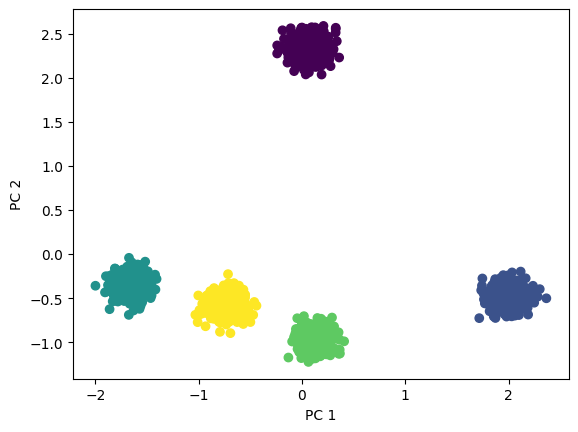

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca.fit_transform(testloader.dataset[:][0].detach().numpy())
labels = testloader.dataset.dataset[:][1][testloader.dataset.indices].detach().numpy()
pca_data = pca.transform(testloader.dataset[:][0].detach().numpy())
print(pca_data.shape)

# visualize pca
fig, ax = plt.subplots()

ax.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

# save fig
plt.show()

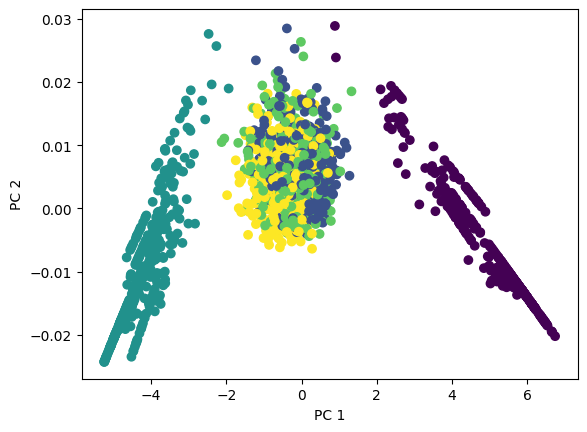

In [12]:
# test model on test data
latent_space = best_model.encode(testloader.dataset[:][0])
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# pca on latent space
pca = PCA(n_components=2)

pca.fit(latent_space[:][0].detach().numpy())
pca_data = pca.transform(latent_space[:][0].detach().numpy())
# visualize pca
fig, ax = plt.subplots()

ax.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
# show fig
plt.show()